<a href="https://colab.research.google.com/github/nxxk23/PROJECT/blob/main/Model/ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.2 MB/s eta 0:00:00


In [3]:
!pip install scikeras

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import shap


In [5]:
bi3 = pd.read_excel('/content/drive/MyDrive/ckdresearch2023/Assign/Assign8 : SplitFold /binary_3_Group_5_Fold.xlsx')
bi3 = bi3.iloc[:, 1:]

In [6]:
bi3['NATNL'] = bi3['NATNL'].replace({0: 'Asian', 1: 'Asian', 3: 'Asian', 2: 'Non-Asian'})

In [7]:
bi3 = bi3.sort_values(['PatientUID', 'PatientVisitUID'])
bi3['TimeDiff'] = bi3.groupby('PatientUID')['LabCwhen'].diff().dt.days / 365
bi3['TimeDiff'] = bi3['TimeDiff'].fillna(0)

In [8]:
bi3['time_t1'] = pd.to_datetime(bi3['time_t1'])

In [9]:
columns_to_encode = ['VisitLocation', 'Group', 'NATNL']

# Apply label encoding using map
for column in columns_to_encode:
    encoding_map = {category: i for i, category in enumerate(bi3[column].unique())}
    bi3[column] = bi3[column].map(encoding_map)

In [10]:
def categorize_eGFR(eGFR_value):
    if eGFR_value >= 90:
        return 0
    elif eGFR_value >= 60:
        return 1
    elif eGFR_value >= 30:
        return 2
    elif eGFR_value >= 15:
        return 3
    else:
        return 4

bi3['Stage'] = bi3['eGFR_t1'].apply(categorize_eGFR)

# GridSearch

In [11]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/xgb_group_binary3.json'
with open(json_file_path, 'r') as f:
    xgb_group_binary3 = json.load(f)

print(xgb_group_binary3)

[{'fold': 1, 'best_params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}, 'best_score': 0.6493697661405065}, {'fold': 2, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': 0.6507247125116574}, {'fold': 3, 'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}, 'best_score': 0.649142205904002}, {'fold': 4, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.6462911661896346}, {'fold': 5, 'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}, 'best_score': 0.6499979700209446}]


In [12]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/rf_group_binary3.json'
with open(json_file_path, 'r') as f:
    rf_group_binary3 = json.load(f)

print(rf_group_binary3)

[{'fold': 1, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}, 'best_score': 0.6359939377634444}, {'fold': 2, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}, 'best_score': 0.6363789957902357}, {'fold': 3, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}, 'best_score': 0.6361862231773203}, {'fold': 4, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}, 'best_score': 0.6346183397692711}, {'fold': 5, 'best_params': {'bootstrap': False, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}, 'best_score': 0.6374801150718877}]


# Split

In [13]:
bi3_X = bi3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
                    'LabCwhen', 'LabLocation', 'Fold','Slopes','Stage','VisitLocation'], axis=1)
bi3_y = bi3['Group']

In [14]:

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
X = bi3.drop(['PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
                'LabCwhen', 'LabLocation', 'Fold', 'Slopes','Group','Stage','VisitLocation'], axis=1)
y = bi3['Group']
all_folds = bi3['Fold'].unique()
X_train_scaled_list_bi3 = []
y_train_list_bi3 = []
X_test_scaled_list_bi3 = []
y_test_list_bi3 = []
for train_folds, test_fold in kf.split(all_folds):
    train_folds = all_folds[train_folds]
    val_fold = all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == val_fold
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_train_scaled_list_bi3.append(X_train_scaled)
    y_train_list_bi3.append(y_train)
    X_test_scaled_list_bi3.append(X_test_scaled)
    y_test_list_bi3.append(y_test)
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold, train_fold_indices) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3, kf.split(all_folds))
):
    train_folds, test_fold = train_fold_indices
    print(f"Training set size: {X_train_scaled_fold.shape}")
    print(f"Test set size: {X_test_scaled_fold.shape}")
    print(f"Folds in training set: {train_folds.tolist()}")
    print(f"Folds in test set: {test_fold}")
    print("---\n")


Training set size: (42274, 119)
Test set size: (10346, 119)
Folds in training set: [1, 2, 3, 4]
Folds in test set: [0]
---

Training set size: (41978, 119)
Test set size: (10642, 119)
Folds in training set: [0, 1, 2, 4]
Folds in test set: [3]
---

Training set size: (42017, 119)
Test set size: (10603, 119)
Folds in training set: [0, 1, 3, 4]
Folds in test set: [2]
---

Training set size: (42027, 119)
Test set size: (10593, 119)
Folds in training set: [0, 1, 2, 3]
Folds in test set: [4]
---

Training set size: (42184, 119)
Test set size: (10436, 119)
Folds in training set: [0, 2, 3, 4]
Folds in test set: [1]
---



In [15]:
bi3['Group'].value_counts()

1    22980
0    16337
2    13303
Name: Group, dtype: int64

## Class

In [16]:
value_mapping = {0: 'rapid', 1: 'better', 2: 'prevention'}
bi3['Group'] = bi3['Group'].replace(value_mapping)

In [17]:
bi3['Group'].value_counts()

better        22980
rapid         16337
prevention    13303
Name: Group, dtype: int64

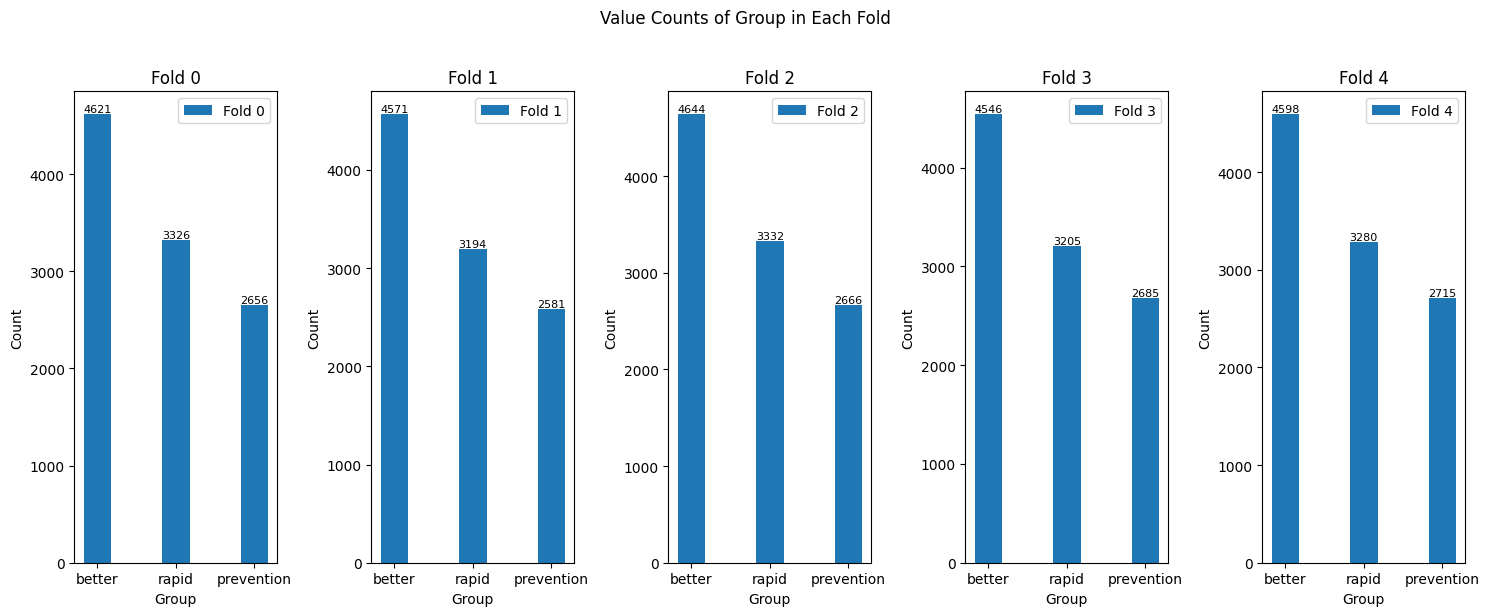

In [18]:
import matplotlib.pyplot as plt
import numpy as np

num_folds = 5
fig, axes = plt.subplots(nrows=1, ncols=num_folds, figsize=(15, 6))  # Use subplots to create separate axes for each fold

bar_width = 0.35
for fold_index, ax in enumerate(axes):
    fold_df = bi3[bi3['Fold'] == fold_index]
    group_value_counts = fold_df['Group'].value_counts()

    bar_positions = np.arange(len(group_value_counts))  # Adjust the positions of the bars based on the number of unique groups

    bars = ax.bar(bar_positions, group_value_counts.values, width=bar_width, label=f'Fold {fold_index}')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(group_value_counts.index)
    ax.set_xlabel('Group')
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f'Fold {fold_index}')
    for bar, count in zip(bars, group_value_counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                ha='center', va='bottom', fontsize=8, color='black')
plt.suptitle('Value Counts of Group in Each Fold', y=1.02)
plt.tight_layout()
plt.show()

# XGB

In [19]:
xgb_group_binary3

[{'fold': 1,
  'best_params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150},
  'best_score': 0.6493697661405065},
 {'fold': 2,
  'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150},
  'best_score': 0.6507247125116574},
 {'fold': 3,
  'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100},
  'best_score': 0.649142205904002},
 {'fold': 4,
  'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
  'best_score': 0.6462911661896346},
 {'fold': 5,
  'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50},
  'best_score': 0.6499979700209446}]

In [20]:
xgb_best_params = xgb_group_binary3[1]['best_params']
xgb_best_params

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

In [21]:
bi3['Group'].value_counts()

better        22980
rapid         16337
prevention    13303
Name: Group, dtype: int64

In [22]:
binary3_X = bi3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation','Fold','Slopes', 'Stage', 'VisitLocation'], axis=1)
binary3_y = bi3['Group']

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict

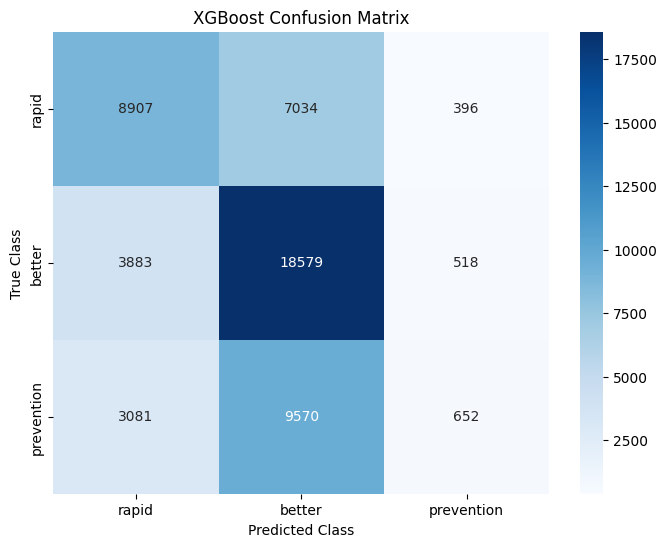

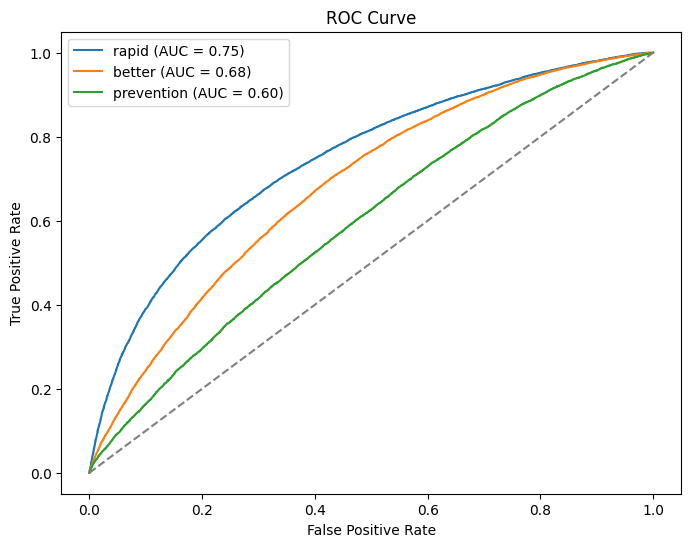

In [24]:
def calculate_performance_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    return accuracy, precision, recall, f1

def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('XGBoost Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
        auc_score = roc_auc_score(y_true == i, y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Initialize DataFrames to store evaluation metrics and predictions
performance_xgb = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
comparison_xgb = pd.DataFrame(columns=['Fold', 'GroupTrue', 'GroupPredicted'])

# Initialize empty lists to store true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Loop through each fold
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3)):

    # Train the model only with the best parameters from fold 3
    xgbmodel = XGBClassifier(**xgb_best_params, objective='multi:softmax', random_state=42)
    xgbmodel.fit(X_train_scaled_fold, y_train_fold)

    # Make predictions on the test data for the current fold
    xgb_y_pred = xgbmodel.predict(X_test_scaled_fold)
    xgb_y_pred_proba = xgbmodel.predict_proba(X_test_scaled_fold)

    # Append the true labels and predicted probabilities
    true_labels.extend(y_test_fold)
    predicted_probabilities.extend(xgb_y_pred_proba)

    # Append the predicted and true values to the DataFrame
    comparison_xgb = pd.concat([comparison_xgb, pd.DataFrame({'Fold': [fold + 1]*len(y_test_fold),
                                                              'GroupTrue': y_test_fold,
                                                              'GroupPredicted': xgb_y_pred})],
                                           ignore_index=True)

    # Calculate evaluation metrics for the current fold
    accuracy, precision, recall, f1 = calculate_performance_metrics(y_test_fold, xgb_y_pred)

    # Append scores to the DataFrame
    performance_xgb.loc[f'Fold {fold + 1}'] = [accuracy, precision, recall, f1]

# Calculate mean scores across all folds
mean_scores = performance_xgb.mean()
performance_xgb.loc['Overall'] = mean_scores

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_true_numeric = label_encoder.fit_transform(comparison_xgb['GroupTrue'])
y_pred_numeric = label_encoder.transform(comparison_xgb['GroupPredicted'])

# Calculate confusion matrix
conf_matrix_xgb = confusion_matrix(y_true_numeric, y_pred_numeric)

# Define label mapping
value_mapping = {0: 'rapid', 1: 'better', 2: 'prevention'}
class_labels = [value_mapping[i] for i in range(len(value_mapping))]

# Plot confusion matrix
plot_confusion_matrix(conf_matrix_xgb, class_labels)

# Plot ROC curve
y_pred_proba = np.array(predicted_probabilities)
plot_roc_curve(y_true_numeric, y_pred_proba, class_labels)


In [25]:
bi3['Group'].value_counts()

better        22980
rapid         16337
prevention    13303
Name: Group, dtype: int64

In [26]:
unique_classes_after = np.unique(y_true_numeric)
class_distribution_after = pd.Series(np.zeros(len(unique_classes_after)), index=unique_classes_after)

# Count occurrences of each encoded class
for label in y_true_numeric:
  class_distribution_after.loc[label] += 1

print("\nClass Distribution After Encoding:")
print(class_distribution_after)


Class Distribution After Encoding:
0    16337.0
1    22980.0
2    13303.0
dtype: float64


In [27]:
print("\nXGBoost Classifier Performances:")
print(performance_xgb)


XGBoost Classifier Performances:
          Accuracy  Precision     Recall   F1-Score
Fold 1   53.392616  49.999913  53.392616  47.040404
Fold 2   53.758692  50.774021  53.758692  47.580200
Fold 3   53.494294  51.201067  53.494294  47.583270
Fold 4   53.252148  51.426879  53.252148  46.826417
Fold 5   53.468762  51.617652  53.468762  47.406149
Overall  53.473302  51.003906  53.473302  47.287288


## shap

In [110]:
import shap
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# Create SHAP explainer object
explainer = shap.TreeExplainer(xgbmodel)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled_fold)

In [129]:
# Train XGBoost model
xgbmodel = XGBClassifier(**xgb_best_params, objective='multi:softmax', random_state=42)
xgbmodel.fit(X_train, y_train)  # Assuming X_train and y_train are your training data


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [130]:
explainer = shap.TreeExplainer(xgbmodel)

In [133]:
print(shap_values.shape)
print(X_test.shape)

(10346, 119, 3)
(10436, 119)


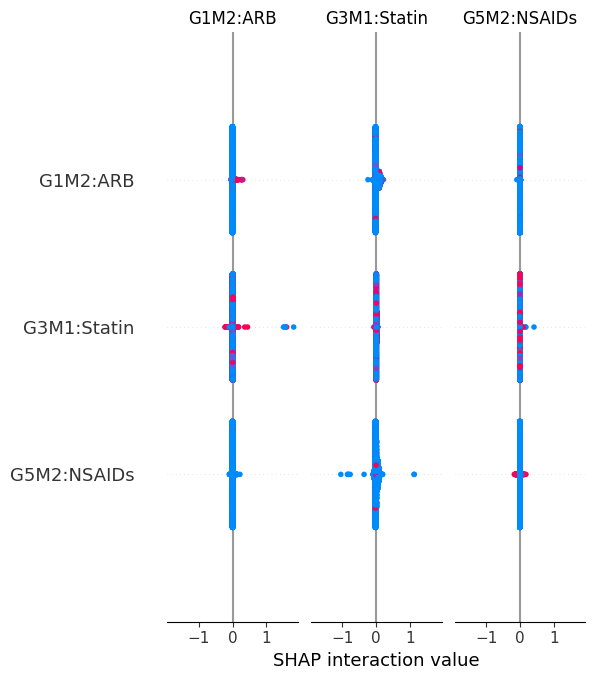

In [137]:
shap.summary_plot(shap_values, X_test_scaled_fold, feature_names=X_test.columns)

In [106]:
# Aggregate SHAP values across classes for each sample
shap_values_reshaped = np.abs(shap_values).mean(axis=2) # Take the mean across the third dimension (classes)
print(shap_values_reshaped.shape)

(10346, 119)


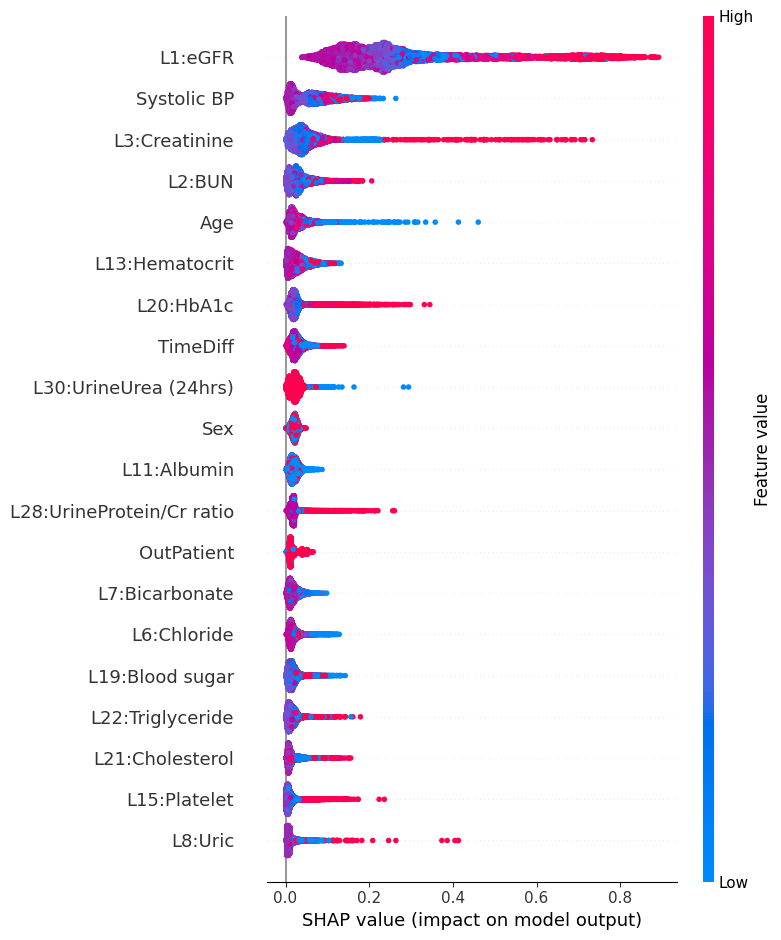

In [107]:
shap.summary_plot(shap_values_reshaped, X_test_scaled_fold, feature_names=X.columns)

In [32]:
shap_values_agg = np.mean(np.abs(shap_values), axis=2)

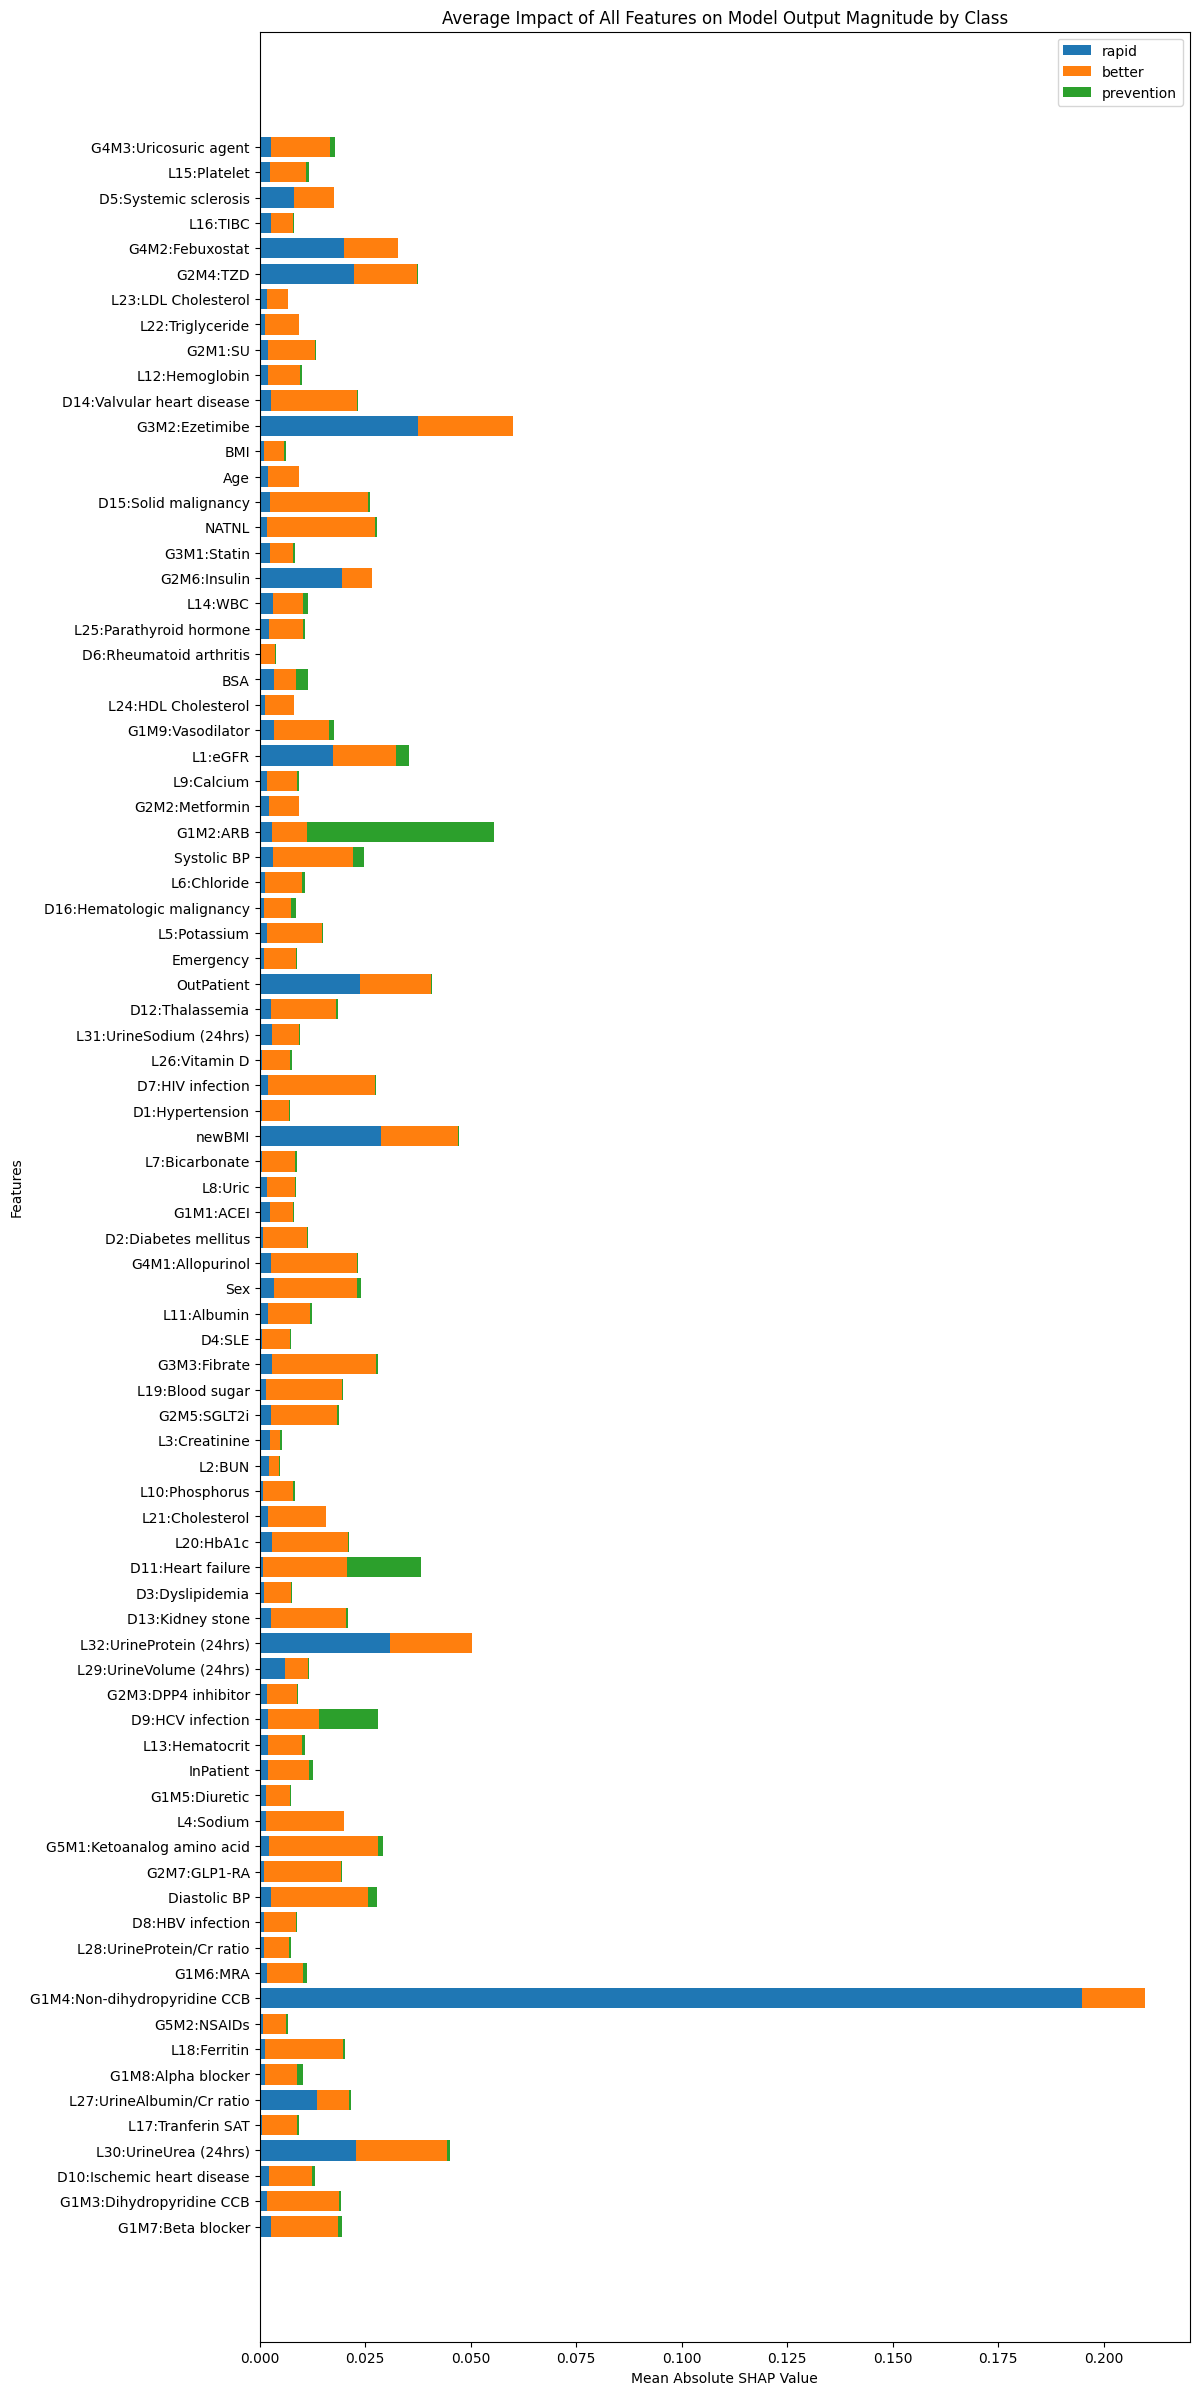

In [34]:
# New label mapping
value_mapping = {0: 'rapid', 1: 'better', 2: 'prevention'}

# New number of classes
num_classes = 3

# Subset of SHAP values
shap_values_agg_all = shap_values_agg[:83, :]
mean_abs_shap_values = np.mean(np.abs(shap_values_agg_all), axis=1)

feature_sort_indices = np.argsort(mean_abs_shap_values)[::-1]
sorted_features = X_test.columns[feature_sort_indices]

# Plotting
plt.figure(figsize=(12, 30))

for class_index in range(num_classes):
    left_offset = np.sum(shap_values_agg_all[feature_sort_indices][:, :class_index], axis=1)
    sorted_shap_values = shap_values_agg_all[feature_sort_indices, class_index]
    plt.barh(range(83), sorted_shap_values, left=left_offset, label=f'{value_mapping[class_index]}')

plt.yticks(range(83), sorted_features)
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.title('Average Impact of All Features on Model Output Magnitude by Class')
plt.legend()
plt.show()


# RF

In [35]:
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV

In [50]:
rf_group_binary3

[{'fold': 1,
  'best_params': {'bootstrap': False,
   'max_depth': None,
   'min_samples_split': 10,
   'n_estimators': 100},
  'best_score': 0.6359939377634444},
 {'fold': 2,
  'best_params': {'bootstrap': False,
   'max_depth': None,
   'min_samples_split': 10,
   'n_estimators': 150},
  'best_score': 0.6363789957902357},
 {'fold': 3,
  'best_params': {'bootstrap': False,
   'max_depth': None,
   'min_samples_split': 10,
   'n_estimators': 150},
  'best_score': 0.6361862231773203},
 {'fold': 4,
  'best_params': {'bootstrap': False,
   'max_depth': None,
   'min_samples_split': 10,
   'n_estimators': 100},
  'best_score': 0.6346183397692711},
 {'fold': 5,
  'best_params': {'bootstrap': False,
   'max_depth': None,
   'min_samples_split': 10,
   'n_estimators': 150},
  'best_score': 0.6374801150718877}]

In [51]:
rf_best_params = rf_group_binary3[4]['best_params']
rf_best_params

{'bootstrap': False,
 'max_depth': None,
 'min_samples_split': 10,
 'n_estimators': 150}

In [52]:
binary3_X = bi3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation','Fold','Slopes', 'Stage', 'VisitLocation'], axis=1)
binary3_y = bi3['Group']

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

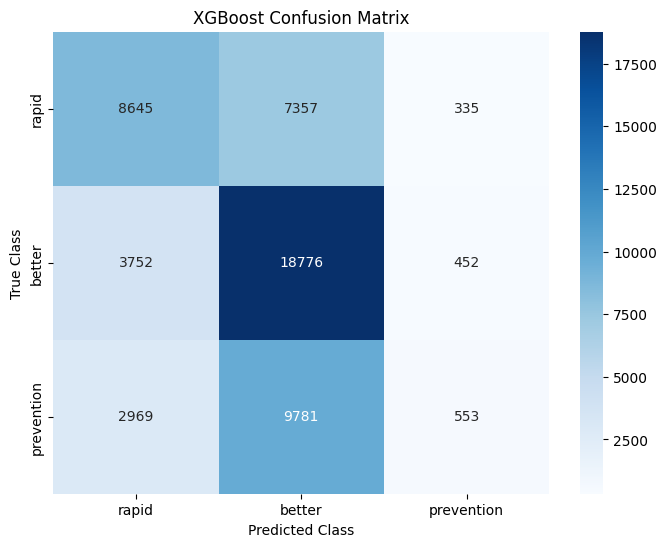

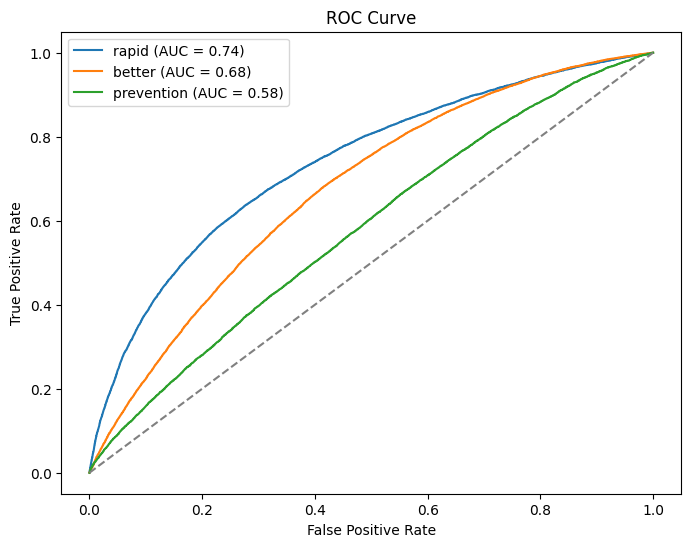

In [53]:
def calculate_performance_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    return accuracy, precision, recall, f1

def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('XGBoost Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
        auc_score = roc_auc_score(y_true == i, y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Initialize DataFrames to store evaluation metrics and predictions
performance_rf = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
comparison_rf = pd.DataFrame(columns=['Fold', 'GroupTrue', 'GroupPredicted'])

# Initialize empty lists to store true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Loop through each fold
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3)):

    # Train the model only with the best parameters
    rfmodel = RandomForestClassifier(**rf_best_params, random_state=42)
    rfmodel.fit(X_train_scaled_fold, y_train_fold)

    # Make predictions on the test data for the current fold
    rf_y_pred = rfmodel.predict(X_test_scaled_fold)
    rf_y_pred_proba = rfmodel.predict_proba(X_test_scaled_fold)

    # Append the true labels and predicted probabilities
    true_labels.extend(y_test_fold)
    predicted_probabilities.extend(rf_y_pred_proba)

    # Append the predicted and true values to the DataFrame
    comparison_rf = pd.concat([comparison_rf, pd.DataFrame({'Fold': [fold + 1]*len(y_test_fold),
                                                              'GroupTrue': y_test_fold,
                                                              'GroupPredicted': rf_y_pred})],
                                           ignore_index=True)

    # Calculate evaluation metrics for the current fold
    accuracy, precision, recall, f1 = calculate_performance_metrics(y_test_fold, rf_y_pred)

    # Append scores to the DataFrame
    performance_rf.loc[f'Fold {fold + 1}'] = [accuracy, precision, recall, f1]

# Calculate mean scores across all folds
mean_scores = performance_rf.mean()
performance_rf.loc['Overall'] = mean_scores

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_true_numeric = label_encoder.fit_transform(comparison_rf['GroupTrue'])
y_pred_numeric = label_encoder.transform(comparison_rf['GroupPredicted'])

# Calculate confusion matrix
conf_matrix_rf = confusion_matrix(y_true_numeric, y_pred_numeric)

# Define label mapping
value_mapping = {0: 'rapid', 1: 'better', 2: 'prevention'}
class_labels = [value_mapping[i] for i in range(len(value_mapping))]

# Plot confusion matrix
plot_confusion_matrix(conf_matrix_rf, class_labels)

# Plot ROC curve
y_pred_proba = np.array(predicted_probabilities)
plot_roc_curve(y_true_numeric, y_pred_proba, class_labels)


In [54]:
print("\nRandom Forest Classifier Performances:")
print(performance_rf)


Random Forest Classifier Performances:
          Accuracy  Precision     Recall   F1-Score
Fold 1   53.353953  49.950173  53.353953  46.823331
Fold 2   53.486187  51.703762  53.486187  47.193850
Fold 3   53.192493  50.675150  53.192493  46.756442
Fold 4   52.780138  50.878382  52.780138  46.209147
Fold 5   52.999233  50.444272  52.999233  46.456148
Overall  53.162401  50.730348  53.162401  46.687783


# FNN

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [72]:
bi3_label_encoder = LabelEncoder()
bi3['Group'] = bi3_label_encoder.fit_transform(bi3['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
bi3_all_folds = bi3['Fold'].unique()

bi3_accuracy_per_fold = []
bi3_conf_mat_list = []

bi3_precision_per_fold = []
bi3_recall_per_fold = []
bi3_f1_per_fold = []

bi3_loss_per_fold = []
bi3_all_train_loss = []
bi3_all_val_loss = []

all_y_true_fnn = []
all_y_pred_proba_fnn = []


In [74]:
for fold, (train_folds, test_fold) in enumerate(kf.split(bi3_all_folds)):
    train_folds = bi3_all_folds[train_folds]
    test_fold = bi3_all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == test_fold

    bi3_X_train, bi3_X_test = bi3_X[train_indices], bi3_X[test_indices]
    bi3_y_train, bi3_y_test = bi3_y[train_indices], bi3_y[test_indices]

    # Scale
    bi3_scaler = StandardScaler()
    bi3_X_train_scaled = bi3_scaler.fit_transform(bi3_X_train)
    bi3_X_test_scaled = bi3_scaler.transform(bi3_X_test)

    # Encode y_train and y_test

    bi3_y_train_one_hot = tf.keras.utils.to_categorical(bi3_y_train, num_classes=3)
    bi3_y_test_one_hot = tf.keras.utils.to_categorical(bi3_y_test, num_classes=len(bi3_label_encoder.classes_))

    # Build and compile the model
    bi3_model = Sequential([
        Dense(256, input_dim=bi3_X_train_scaled.shape[1], activation='relu'),
        Dropout(0.6),
        Dense(128, activation='relu'),
        Dropout(0.6),
        Dense(64, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
    ])

    bi3_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    bi3_model.compile(optimizer=bi3_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    bi3_history = bi3_model.fit(bi3_X_train_scaled, bi3_y_train_one_hot,
                                batch_size=32,
                                epochs=80,
                                verbose=0,
                                validation_data=(bi3_X_test_scaled, bi3_y_test_one_hot))

    # Evaluate on the test set
    bi3_scores = bi3_model.evaluate(bi3_X_test_scaled, bi3_y_test_one_hot, verbose=0)
    bi3_loss_per_fold.append(bi3_scores[0])

    # Store metrics for analysis
    bi3_all_train_loss.append(bi3_history.history['loss'])
    bi3_all_val_loss.append(bi3_history.history['val_loss'])

    bi3_y_pred = bi3_model.predict(bi3_X_test_scaled)
    bi3_y_pred_classes = np.argmax(bi3_y_pred, axis=1)

    bi3_y_pred_proba_fnn = bi3_y_pred
    all_y_true_fnn.extend(bi3_y_test)
    all_y_pred_proba_fnn.extend(bi3_y_pred_proba_fnn[:, 1])

    bi3_conf_mat = confusion_matrix(bi3_y_test, bi3_y_pred_classes)
    bi3_conf_mat_list.append(bi3_conf_mat)

    bi3_accuracy = accuracy_score(bi3_y_test, bi3_y_pred_classes)
    bi3_precision = precision_score(bi3_y_test, bi3_y_pred_classes, average='weighted')
    bi3_recall = recall_score(bi3_y_test, bi3_y_pred_classes, average='weighted')
    bi3_f1 = f1_score(bi3_y_test, bi3_y_pred_classes, average='weighted')

    bi3_accuracy_per_fold.append(bi3_accuracy)
    bi3_precision_per_fold.append(bi3_precision)
    bi3_recall_per_fold.append(bi3_recall)
    bi3_f1_per_fold.append(bi3_f1)

324/324 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


327/327 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


332/332 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


333/333 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


332/332 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
import pandas as pd

# Create a DataFrame for performance metrics of each fold
fold_data = {
    "Fold": [f"Fold {fold+1}" for fold in range(len(bi3_accuracy_per_fold))],
    "Accuracy (%)": [accuracy * 100 for accuracy in bi3_accuracy_per_fold],
    "Precision": bi3_precision_per_fold,
    "Recall": bi3_recall_per_fold,
    "F1-Score": bi3_f1_per_fold
}

# Create DataFrame for fold performance
fold_performance_df = pd.DataFrame(fold_data).set_index("Fold")


# Calculate overall performance metrics
overall_metrics = {
    "Accuracy (%)": sum(bi3_accuracy_per_fold) / len(bi3_accuracy_per_fold) * 100,
    "Precision": sum(bi3_precision_per_fold) / len(bi3_precision_per_fold),
    "Recall": sum(bi3_recall_per_fold) / len(bi3_recall_per_fold),
    "F1-Score": sum(bi3_f1_per_fold) / len(bi3_f1_per_fold)
}

# Create DataFrame for overall performance
overall_performance_df = pd.DataFrame(overall_metrics, index=["Overall"])

# Concatenate fold performance DataFrame with overall performance DataFrame
result_fnn = pd.concat([fold_performance_df, overall_performance_df])

# Print the concatenated DataFrame
print("\nFNN Performance to classify Group:")
result_fnn


FNN Performance to classify Group:


,Accuracy (%),Precision,Recall,F1-Score
Fold 1,52.783685,0.396741,0.527837,0.448817
Fold 2,51.868532,0.384702,0.518685,0.441621
Fold 3,50.618333,0.399647,0.506183,0.413608
Fold 4,52.894193,0.396229,0.528942,0.451627
Fold 5,52.683203,0.395979,0.526832,0.448442
Overall,52.169589,0.394660,0.521696,0.440823


In [ ]:
# Print the concatenated DataFrame
print("\nFNN Performance to classify Group:")
print(result_fnn)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Convert true labels to one-hot encoded format
bi3_y_test_bin = label_binarize(bi3_y_test, classes=np.unique(bi3_y_test))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = bi3_y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bi3_y_test_bin[:, i], bi3_y_pred_proba_fnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
# First, aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally, average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

class_labels = {0: "better", 1: "rapid (decrease)", 2: "prevention"}

# Plot ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:0.2f})', color='red', linestyle='solid', linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({class_labels[i]}) (AUC = {roc_auc[i]:0.2f})', alpha = 0.8, linestyle = '-.')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for FNN Classification')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

num_epochs = len(bi3_all_train_loss[0])  # Assuming all folds have the same number of epochs

fig, axs = plt.subplots(1, num_folds, figsize=(32, 6), sharex=True, sharey=True)

for fold in range(num_folds):
    axs[fold].plot(range(1, num_epochs + 1), bi3_all_train_loss[fold], label=f'Train Loss')
    axs[fold].plot(range(1, num_epochs + 1), bi3_all_val_loss[fold], label=f'Validation Loss')
    axs[fold].set_title(f'Fold {fold + 1}')
    axs[fold].set_xlabel('Epoch')
    axs[fold].set_ylabel('Loss')
    axs[fold].legend()

plt.suptitle('Training and Validation Loss per Epoch for each Fold')
plt.tight_layout()
plt.show()


# SVC

In [ ]:
from sklearn.svm import SVC
from sklearn import svm

In [ ]:
binary3_X = bi3.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation','Fold','Slopes','Stage'], axis=1)
binary3_y = bi3['Group']

In [ ]:
binary3_label_encoder = LabelEncoder()
bi3['Group'] = binary3_label_encoder.fit_transform(bi3['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
binary3_all_folds = bi3['Fold'].unique()

svc_metrics_list = []
binary3_accuracy_per_fold = []
binary3_conf_mat_list = []
binary3_precision_per_fold = []
binary3_recall_per_fold = []
binary3_f1_per_fold = []
binary3_loss_per_fold = []

all_y_true_svc = []
all_y_pred_proba_svc = []



```
for fold, (train_folds, test_fold) in enumerate(kf.split(binary3_all_folds)):
    train_folds = binary3_all_folds[train_folds]
    test_fold = binary3_all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == test_fold

    binary3_X_train, binary3_X_test = binary3_X[train_indices], binary3_X[test_indices]
    binary3_y_train, binary3_y_test = binary3_y[train_indices], binary3_y[test_indices]

    # Scale
    binary3_scaler = StandardScaler()
    binary3_X_train_scaled = binary3_scaler.fit_transform(binary3_X_train)
    binary3_X_test_scaled = binary3_scaler.transform(binary3_X_test)

    # Create and train SVC model using best parameters
    model_svc = svm.SVC(decision_function_shape='ovo', probability=True)
    model_svc.fit(binary3_X_train_scaled, binary3_y_train)

    # Make predictions on the test set
    binary3_y_pred = model_svc.predict(binary3_X_test_scaled)

    binary3_y_pred_proba_svc = model_svc.decision_function(binary3_X_test_scaled)
    all_y_true_svc.extend(binary3_y_test)
    all_y_pred_proba_svc.extend(binary3_y_pred_proba_svc[:, 1])

    # Evaluate performance
    binary3_conf_mat = confusion_matrix(binary3_y_test, binary3_y_pred)
    binary3_conf_mat_list.append(binary3_conf_mat)
    binary3_accuracy = accuracy_score(binary3_y_test, binary3_y_pred)
    binary3_precision = precision_score(binary3_y_test, binary3_y_pred, average='weighted')
    binary3_recall = recall_score(binary3_y_test, binary3_y_pred, average='weighted')
    binary3_f1 = f1_score(binary3_y_test, binary3_y_pred, average='weighted')
    
    binary3_accuracy_per_fold.append(binary3_accuracy)
    binary3_precision_per_fold.append(binary3_precision)
    binary3_recall_per_fold.append(binary3_recall)
    binary3_f1_per_fold.append(binary3_f1)

    svc_metrics_list.append({
        'Fold': fold + 1,
        'Accuracy': binary3_accuracy_per_fold,
        'Precision': binary3_precision_per_fold,
        'Recall': binary3_recall_per_fold,
        'F1 Score': binary3_f1_per_fold,
    })
```



## Result from server

In [57]:
result_svc = pd.read_csv('/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/result_svc.csv')

In [58]:
print("\n Support Vector Classification Performances:")
print(result_svc)


 Support Vector Classification Performances:
  Unnamed: 0  Accuracy (%)  Precision    Recall  F1-Score
0     Fold 1     51.411309   0.483219  0.514113  0.438821
1     Fold 2     52.745022   0.492369  0.527450  0.450426
2     Fold 3     51.982710   0.475439  0.519827  0.442754
3     Fold 4     51.945190   0.481012  0.519452  0.442359
4     Fold 5     52.485146   0.504197  0.524851  0.448523
5    Overall     52.113875   0.487247  0.521139  0.444577


## ROC

In [69]:
# Load the array
import numpy as np
binary3_y_pred_proba_svc = np.load('/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/binary3_y_pred_proba_svc.npy')

# Now you can use binary3_y_pred_proba_svc in your Colab notebook
print(binary3_y_pred_proba_svc)

[[-0.02650403  0.52128657  0.76594442]
 [-0.28683925 -0.09056781  0.81931317]
 [ 0.10690912  0.22974389  0.85456098]
 ...
 [-0.10817442  1.20458718  1.04993297]
 [ 0.31241888  1.06616499  0.93443532]
 [-0.85368739 -0.78824982  0.69518793]]


In [70]:
print(binary3_y_pred_proba_svc.shape)

(10603, 3)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Convert true labels to one-hot encoded format
binary3_y_test_bin = label_binarize(bi3_y_test, classes=np.unique(bi3_y_test))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = binary3_y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bi3_y_test_bin[:, i], binary3_y_pred_proba_svc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
# First, aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally, average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

class_labels = {0: "better", 1: "rapid (decrease)", 2: "prevention"}

# Plot ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:0.2f})', color='red', linestyle='solid', linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({class_labels[i]}) (AUC = {roc_auc[i]:0.2f})', alpha = 0.8, linestyle = '-.')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Support Vetor Classification')
plt.legend(loc="lower right")
plt.show()


#Summary

In [ ]:
result_rf['Accuracy'] *= 100

In [ ]:
test = pd.concat([result_xgb[-1:], result_rf[-1:], result_fnn[-1:], result_svc[-1:]], keys=['XGBoost', 'RandomForest', 'Feedforward Neural Network', 'Support Vector Machine'])
import pandas as pd

# Concatenating the DataFrames
test = pd.concat([result_xgb.iloc[-1:], result_rf.iloc[-1:], result_fnn.iloc[-1:], result_svc[-1:]], keys=['XGBoost', 'RandomForest', 'Feedforward Neural Network', 'Support Vector Machine'])

# Remove the index named 'Overall'
test.reset_index(level=1, drop=True, inplace=True)

# Renaming the 'F1 Score' column in the RandomForest section
test.loc['RandomForest', 'F1-Score'] = test.loc['RandomForest', 'F1 Score']
test.drop(columns='F1 Score', inplace=True)
# Renaming the 'F1 Score' column in the RandomForest section
test.loc['RandomForest', 'Accuracy (%)'] = test.loc['RandomForest', 'Accuracy']
test.drop(columns='Accuracy', inplace=True)
test.drop(columns='Unnamed: 0', inplace =True)

In [ ]:
print(test)

                            Accuracy (%)  Precision    Recall  F1-Score
XGBoost                        53.534079   0.510090  0.535341  0.473611
RandomForest                   52.668744   0.524603  0.526687  0.453119
Feedforward Neural Network     52.309902   0.393249  0.523099  0.443251
Support Vector Machine         52.113875   0.487247  0.521139  0.444577


## avg ROC

In [ ]:
all_y_true_rf_encoded = np.array(all_y_true_rf_encoded)
all_y_pred_proba_rf = np.array(all_y_pred_proba_rf)

In [ ]:
all_y_pred_proba_rf = np.array(all_y_pred_proba_rf)  # Convert to numpy array if it's not already
all_y_pred_proba_rf = all_y_pred_proba_rf.reshape(-1, 3)  # Reshape to match the shape of all_y_true_rf_encoded

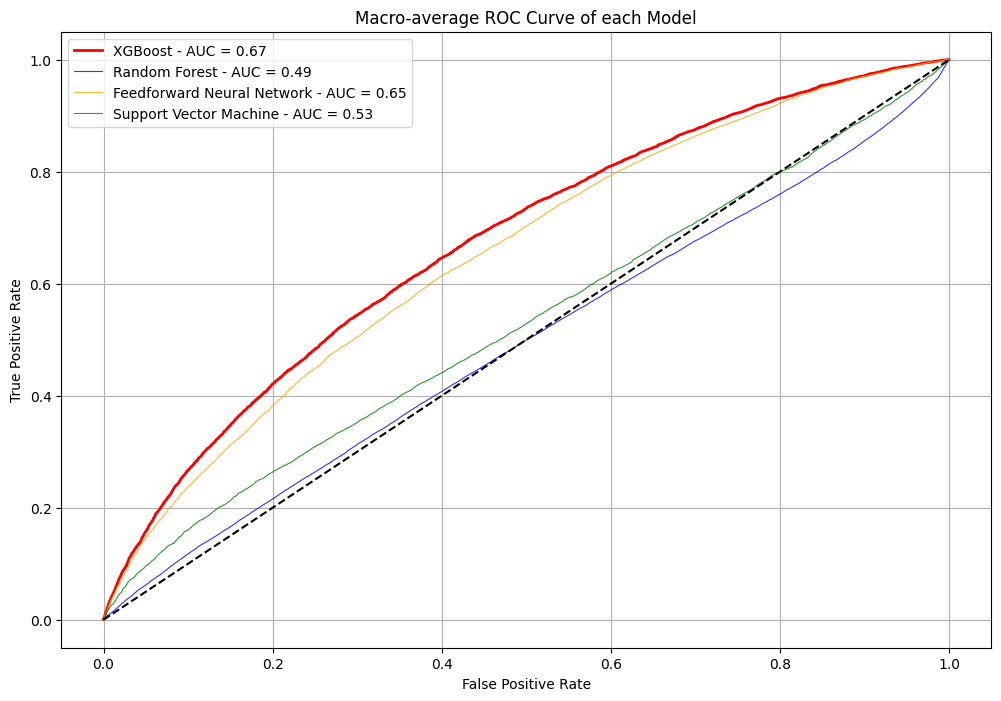

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Assuming you have defined all_y_true_rf, all_y_pred_proba_rf, all_y_pred_proba_xgb, bi3_y_test,
# bi3_y_pred_proba_fnn, binary3_y_pred_proba_svc, binary3_y_test, binary3_y_pred_proba_xgb, binary3_y_pred_proba_svc somewhere

# Convert true labels to one-hot encoded format
all_y_true_rf_encoded = label_binarize(all_y_true_rf, classes=np.unique(all_y_true_rf))
binary3_y_test_bin = label_binarize(binary3_y_test, classes=np.unique(binary3_y_test))
bi3_y_test_bin = label_binarize(bi3_y_test, classes=np.unique(bi3_y_test))

# Define class labels
class_labels = {0: "better", 1: "rapid (decrease)", 2: "prevention"}

# Compute ROC curve and AUC for XGBoost for each class separately
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()

n_classes_xgb = binary3_y_test_bin.shape[1]
for i in range(n_classes_xgb):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(binary3_y_test_bin[:, i], binary3_y_pred_proba_xgb[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])

# Compute ROC curve and AUC for Random Forest (rf) for each class separately
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

# Define class labels
for i, label in class_labels.items():
    fpr_rf[i], tpr_rf[i], _ = roc_curve(all_y_true_rf_encoded[:, i], all_y_pred_proba_rf)
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])


# Calculate AUC for macro-average ROC
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Compute ROC curve and AUC for FNN for each class separately
fpr_fnn = dict()
tpr_fnn = dict()
roc_auc_fnn = dict()

n_classes_fnn = bi3_y_test_bin.shape[1]
for i in range(n_classes_fnn):
    fpr_fnn[i], tpr_fnn[i], _ = roc_curve(bi3_y_test_bin[:, i], bi3_y_pred_proba_fnn[:, i])
    roc_auc_fnn[i] = auc(fpr_fnn[i], tpr_fnn[i])

# Compute ROC curve and AUC for SVC for each class separately
fpr_svc = dict()
tpr_svc = dict()
roc_auc_svc = dict()

n_classes_svc = binary3_y_test_bin.shape[1]
for i in range(n_classes_svc):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(bi3_y_test_bin[:, i], binary3_y_pred_proba_svc[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])

# Compute macro-average ROC curve and AUC for XGBoost
all_fpr_xgb = np.unique(np.concatenate([fpr_xgb[i] for i in range(n_classes_xgb)]))
mean_tpr_xgb = np.zeros_like(all_fpr_xgb)
for i in range(n_classes_xgb):
    mean_tpr_xgb += np.interp(all_fpr_xgb, fpr_xgb[i], tpr_xgb[i])
mean_tpr_xgb /= n_classes_xgb
fpr_macro_xgb = all_fpr_xgb
tpr_macro_xgb = mean_tpr_xgb
roc_auc_macro_xgb = auc(fpr_macro_xgb, tpr_macro_xgb)

# Compute macro-average ROC curve and AUC for Random Forest (rf)
all_fpr_rf = np.unique(np.concatenate([fpr_rf[i] for i in range(n_classes_rf)]))
mean_tpr_rf = np.zeros_like(all_fpr_rf)
for i in range(len(class_labels)):
    mean_tpr_rf += np.interp(all_fpr_rf, fpr_rf[i], tpr_rf[i])
mean_tpr_rf /= len(class_labels)
fpr_macro_rf = all_fpr_rf
tpr_macro_rf = mean_tpr_rf
roc_auc_macro_rf = auc(fpr_macro_rf, tpr_macro_rf)

# Compute macro-average ROC curve and AUC for FNN
all_fpr_fnn = np.unique(np.concatenate([fpr_fnn[i] for i in range(n_classes_fnn)]))
mean_tpr_fnn = np.zeros_like(all_fpr_fnn)
for i in range(n_classes_fnn):
    mean_tpr_fnn += np.interp(all_fpr_fnn, fpr_fnn[i], tpr_fnn[i])
mean_tpr_fnn /= n_classes_fnn
fpr_macro_fnn = all_fpr_fnn
tpr_macro_fnn = mean_tpr_fnn
roc_auc_macro_fnn = auc(fpr_macro_fnn, tpr_macro_fnn)

# Compute macro-average ROC curve and AUC for SVC
all_fpr_svc = np.unique(np.concatenate([fpr_svc[i] for i in range(n_classes_svc)]))
mean_tpr_svc = np.zeros_like(all_fpr_svc)
for i in range(n_classes_svc):
    mean_tpr_svc += np.interp(all_fpr_svc, fpr_svc[i], tpr_svc[i])
mean_tpr_svc /= n_classes_svc
fpr_macro_svc = all_fpr_svc
tpr_macro_svc = mean_tpr_svc
roc_auc_macro_svc = auc(fpr_macro_svc, tpr_macro_svc)

plt.figure(figsize=(12, 8))
# Plot macro-average ROC curve
plt.plot(fpr_macro_xgb, tpr_macro_xgb, label=f'XGBoost - AUC = {roc_auc_macro_xgb:.2f}', color='red', linestyle='solid', lw=2)
plt.plot(fpr_macro_rf, tpr_macro_rf, label=f'Random Forest - AUC = {roc_auc_macro_rf:.2f}', color='blue', linestyle='solid', alpha=0.8, lw=0.8)
plt.plot(fpr_macro_fnn, tpr_macro_fnn, label=f'Feedforward Neural Network - AUC = {roc_auc_macro_fnn:.2f}', color='orange', linestyle='solid', alpha=0.8, lw=0.8)
plt.plot(fpr_macro_svc, tpr_macro_svc, label=f'Support Vector Machine - AUC = {roc_auc_macro_svc:.2f}', color='green', linestyle='solid', alpha=0.8, lw=0.8)

# Plot the center diagonal line
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.title('Macro-average ROC Curve of each Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()
